# HW2.
Эта версия после 23:59, но я поставил на ночь считаться, чтобы получить лучше цифры (а так код такой не сильно поменялся). 

In [3]:
import random
import gc
import json
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
SEED = 42
if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)

In [5]:
data_path = Path('kkbox-music-recommendation-challenge')

# Feature engineering
### Songs features:
* количество указанных жанров
* количество артистов
* количество композиторов
* количество авторов текста
* также отдельно выделим первый жанр, если их несколько
* в каком году выпущена песня
* не будем удалять имя артиста, так как их относительно размера датасета не так уж и много (221789 к 7377418 $\approx$ 0.03, к тому же тех, кто встречается достаточно редко можно будет загладить приором, к тому же может быть действительно каких-то испольнителей переслушивают, а каких-то нет)

In [6]:
songs = pd.read_csv(data_path / 'songs.csv')
song_extra_info = pd.read_csv(data_path / 'song_extra_info.csv')

In [7]:
songs = songs.merge(song_extra_info, on='song_id', how='left')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


In [8]:
def number_of(x, column_name):
    value = x[column_name]
    if pd.isna(value):
        return 0
    value = str(value)
    return 1 + value.count('|') + value.count('/') + value.count('//') + value.count('&') + value.count(';') + value.count('and')

def count_of(df, column_name):
    return df.progress_apply(lambda x: number_of(x, column_name), axis=1)

In [9]:
songs['num_genres'] = count_of(songs, 'genre_ids')
songs['num_artists'] = count_of(songs, 'artist_name')
songs['num_composers'] = count_of(songs, 'composer')
songs['num_lyricists'] = count_of(songs, 'lyricist')
songs['main_genre'] = songs['genre_ids'].str.split('|').str[0]

In [10]:
def isrc_to_year(isrc):
    if pd.isna(isrc):
        return isrc
    if int(isrc[5:7]) > 17:
        return 1900 + int(isrc[5:7])
    return 2000 + int(isrc[5:7])

In [11]:
songs['year'] = songs['isrc'].progress_apply(isrc_to_year)

In [12]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,num_genres,num_artists,num_composers,num_lyricists,main_genre,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010,1,1,1,1,465,2014.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN,1,1,3,1,444,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN,1,1,0,0,465,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108,1,1,1,1,465,2002.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN,1,1,1,1,726,NaN


In [13]:
songs['artist_name'] = songs['artist_name'].str.lower()
song_columns_to_drop = ['composer', 'lyricist', 'name', 'isrc']
songs = songs.drop(columns=song_columns_to_drop)

In [14]:
songs.head()

,song_id,song_length,genre_ids,artist_name,language,num_genres,num_artists,num_composers,num_lyricists,main_genre,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (jeff chang),3.0,1,1,1,1,465,2014.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,blackpink,31.0,1,1,3,1,444,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,super junior,31.0,1,1,0,0,465,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,s.h.e,3.0,1,1,1,1,465,2002.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,52.0,1,1,1,1,726,NaN


### Members features:
* Отфильтруем нереалистичные значения возраста
> bd: age. Note: this column has outlier values, please use your judgement.
* переведем в datetime
* добавим сколько уже пользователь

In [15]:
members = pd.read_csv(data_path / 'members.csv')

In [16]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [17]:
members.loc[(members['bd'] < 12) | (members['bd'] > 100), 'bd'] = np.nan

In [18]:
def extract_date(x):
    x = str(x)
    year = int(x[:4])
    month = int(x[4:6])
    day = int(x[6:])
    return [day, month, year]

from datetime import datetime

def how_long_user(x):
    start_date = datetime(year=x['registration_year'], month=x['registration_month'], day=x['registration_day'])
    end_date = datetime(year=x['expiration_year'], month=x['expiration_month'], day=x['expiration_day'])
    return (end_date - start_date).days

In [19]:
members[['registration_day', 'registration_month', 'registration_year']] = members.progress_apply(lambda x: extract_date(x['registration_init_time']), result_type='expand', axis=1)
members[['expiration_day', 'expiration_month', 'expiration_year']] = members.progress_apply(lambda x: extract_date(x['expiration_date']), result_type='expand', axis=1)

members['how_long_user'] = members.progress_apply(how_long_user, axis=1)

In [20]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_day,registration_month,registration_year,expiration_day,expiration_month,expiration_year,how_long_user
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,NaN,NaN,7,20110820,20170920,20,8,2011,20,9,2017,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,NaN,NaN,7,20150628,20170622,28,6,2015,22,6,2017,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,NaN,NaN,4,20160411,20170712,11,4,2016,12,7,2017,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,NaN,NaN,9,20150906,20150907,6,9,2015,7,9,2015,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,NaN,NaN,4,20170126,20170613,26,1,2017,13,6,2017,138


In [21]:
members_to_drop = ['registration_init_time', 'expiration_date']
members = members.drop(columns=members_to_drop)

In [22]:
import gc
gc.collect()

72

### Train:
* Добавим фичи про экран
* Из плейлиста
* Целеноправленно ли вбил в поиск

In [23]:
train = pd.read_csv(data_path / 'train.csv')
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [24]:
train['is_local'] = train['source_type'].str.contains('local').astype(np.bool)
train['is_playlist'] = train['source_type'].str.contains('playlist').astype(np.bool)
train['is_discover'] = train['source_screen_name'].str.contains('Discover').astype(np.bool)
train['is_search'] = train['source_screen_name'].str.contains('Search').astype(np.bool)

In [25]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,is_local,is_playlist,is_discover,is_search
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,True,False,False
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,False,False
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,False,False
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,False,False
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,True,False,False


In [26]:
train = train.merge(members, on='msno', how='left')
train = train.merge(songs, on='song_id', how='left')

In [27]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,is_local,is_playlist,is_discover,is_search,...,song_length,genre_ids,artist_name,language,num_genres,num_artists,num_composers,num_lyricists,main_genre,year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,True,False,False,...,206471.0,359,bastille,52.0,1.0,1.0,2.0,0.0,359,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,284584.0,1259,various artists,52.0,1.0,1.0,0.0,0.0,1259,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,225396.0,1259,nas,52.0,1.0,1.0,1.0,0.0,1259,2006.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,False,False,...,255512.0,1019,soundway,-1.0,1.0,1.0,1.0,0.0,1019,2010.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,True,False,False,...,187802.0,1011,brett young,52.0,1.0,1.0,3.0,0.0,1011,2016.0


### Счетчики
(да, тут небольшой лик)

In [28]:
stats_by_user = train.groupby(by='msno').size().reset_index(name='user_size')
stats_by_song = train.groupby(by='song_id').size().reset_index(name='song_size')

In [29]:
train = train.merge(stats_by_user, on='msno', how='left')
train = train.merge(stats_by_song, on='song_id', how='left')

In [30]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'is_local', 'is_playlist', 'is_discover',
       'is_search', 'city', 'bd', 'gender', 'registered_via',
       'registration_day', 'registration_month', 'registration_year',
       'expiration_day', 'expiration_month', 'expiration_year',
       'how_long_user', 'song_length', 'genre_ids', 'artist_name', 'language',
       'num_genres', 'num_artists', 'num_composers', 'num_lyricists',
       'main_genre', 'year', 'user_size', 'song_size'],
      dtype='object')

# Fit-predict
По хорошему нужно cv, но датасет достаточно большой, поэтому в общем случае ограничемся просто holdout-ом

In [31]:
from lightgbm import LGBMClassifier

In [32]:
X, y = train.drop(columns=['msno', 'song_id', 'target']), train['target']

In [33]:
categorical_columns = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name', 'city', 'gender', 'registered_via', 'genre_ids', 'language', 'main_genre']

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [50]:
def get_classifier(n_estimators=300, boosting_type='gbdt'):
    clf = LGBMClassifier(
                boosting_type=boosting_type, # - при использовании dart можно улучшить метрики (правда модель обучается сильно дольше)
                n_estimators=n_estimators, # int(1e6), # - лучше всего строить деревья, пока не упремся в overfitting по validate, но тут это очень и очень долго
                learning_rate=0.5, # 0.03,
                num_leaves=30,
                colsample_bytree=.8,
                subsample=.9,
                max_depth=7,
                reg_alpha=.3,
                reg_lambda=.1,
                min_split_gain=.01,
                min_child_weight=2,
                verbose=0 
    )
    return clf

In [51]:
def test_perfomance(encoder, clf, X_train, X_valid, y_train, y_valid, early_stopping_rounds=40, categorical_feature='auto'):
    X_train_transformed = encoder.fit_transform(X_train, y_train)
    X_valid_transformed = encoder.transform(X_valid)
    clf.fit(
            X_train_transformed, y_train, 
            eval_set= [(X_train_transformed, y_train), (X_valid_transformed, y_valid)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds, 
            feature_name=list(X_train.columns), categorical_feature=categorical_feature
    )
    print(f'roc-auc: {roc_auc_score(y_valid, clf.predict_proba(X_valid_transformed)[:, 1])}')
    return encoder, clf

Потестируем различные энкодеры

In [37]:
import category_encoders as ce

In [38]:
ordinal_encoder = ce.OrdinalEncoder(cols=categorical_columns)
james_encoder = ce.JamesSteinEncoder(cols=categorical_columns)
catboost_encoder = ce.CatBoostEncoder(cols=categorical_columns)

In [103]:
_ = test_perfomance(ordinal_encoder, get_classifier(), X_train, X_valid, y_train, y_valid, categorical_feature=categorical_columns)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.740068	training's binary_logloss: 0.599236	valid_1's auc: 0.731149	valid_1's binary_logloss: 0.606382
[200]	training's auc: 0.756079	training's binary_logloss: 0.586015	valid_1's auc: 0.741993	valid_1's binary_logloss: 0.597915
[300]	training's auc: 0.765622	training's binary_logloss: 0.57765	valid_1's auc: 0.747516	valid_1's binary_logloss: 0.5934
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.765622	training's binary_logloss: 0.57765	valid_1's auc: 0.747516	valid_1's binary_logloss: 0.5934
roc-auc: 0.7475163997854221


In [106]:
_ = test_perfomance(james_encoder, get_classifier(), X_train, X_valid, y_train, y_valid)

C:\Miniconda3\envs\recsys\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.737877	training's binary_logloss: 0.600334	valid_1's auc: 0.732347	valid_1's binary_logloss: 0.610575
[200]	training's auc: 0.752726	training's binary_logloss: 0.588381	valid_1's auc: 0.746147	valid_1's binary_logloss: 0.59995
[300]	training's auc: 0.761799	training's binary_logloss: 0.580581	valid_1's auc: 0.754312	valid_1's binary_logloss: 0.593453
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.761799	training's binary_logloss: 0.580581	valid_1's auc: 0.754312	valid_1's binary_logloss: 0.593453
roc-auc: 0.7543117376240815


In [107]:
cb_enc, cb_clf = test_perfomance(catboost_encoder, get_classifier(), X_train, X_valid, y_train, y_valid)

C:\Miniconda3\envs\recsys\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.733529	training's binary_logloss: 0.604812	valid_1's auc: 0.732931	valid_1's binary_logloss: 0.605235
[200]	training's auc: 0.747564	training's binary_logloss: 0.593752	valid_1's auc: 0.745462	valid_1's binary_logloss: 0.595411
[300]	training's auc: 0.757054	training's binary_logloss: 0.585677	valid_1's auc: 0.753604	valid_1's binary_logloss: 0.588526
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.757054	training's binary_logloss: 0.585677	valid_1's auc: 0.753604	valid_1's binary_logloss: 0.588526
roc-auc: 0.7536038950205189


Видно, что даже с одним и тем же классификатором от работы с категориальными фичами зависит на 0.01.   
(и тут нет лика, так как мы статистики только по train считаем)
## Feature importance

In [55]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [56]:
def plot_importance(model, importance_type='split'):
    """
    importance_type could be split or 'gain'
    """
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = X_train.columns
    feat_importance[importance_type] = model.feature_importance(importance_type=importance_type)
    feat_importance = feat_importance.sort_values(by=importance_type, ascending=False).head(20)
    fig = plt.figure(figsize=(20, 10)) 
    ax = sns.barplot(y="feature", x=importance_type, data=feat_importance) 
    plt.show() 
    fig.savefig(f"feature_importance_{importance_type}.png")

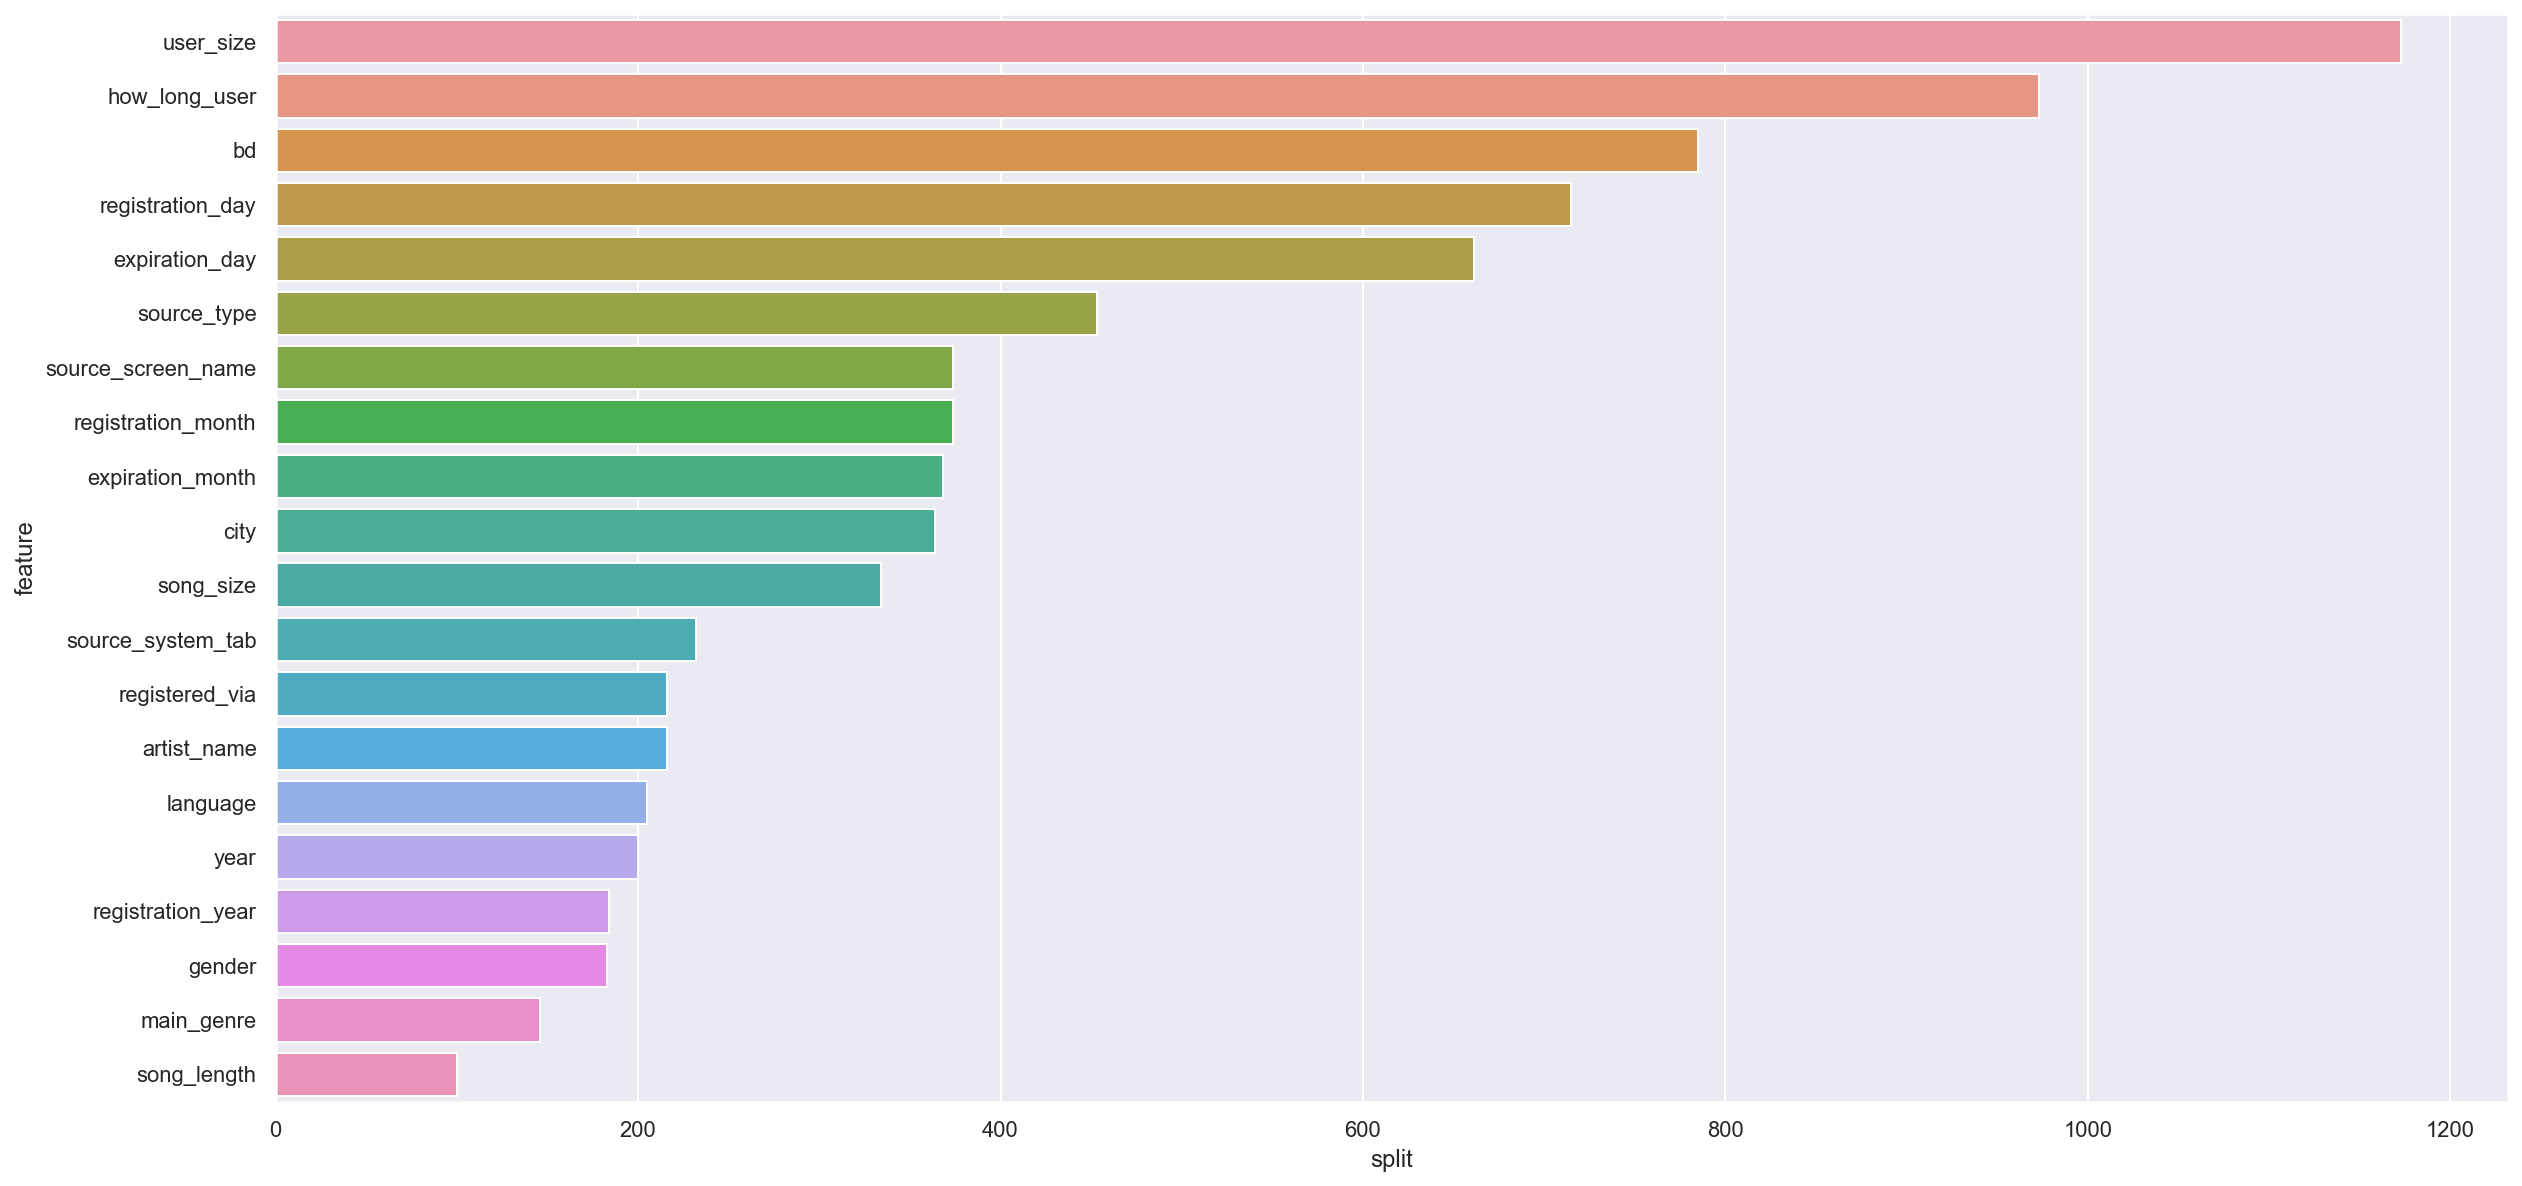

In [113]:
plot_importance(cb_clf.booster_, importance_type='split')

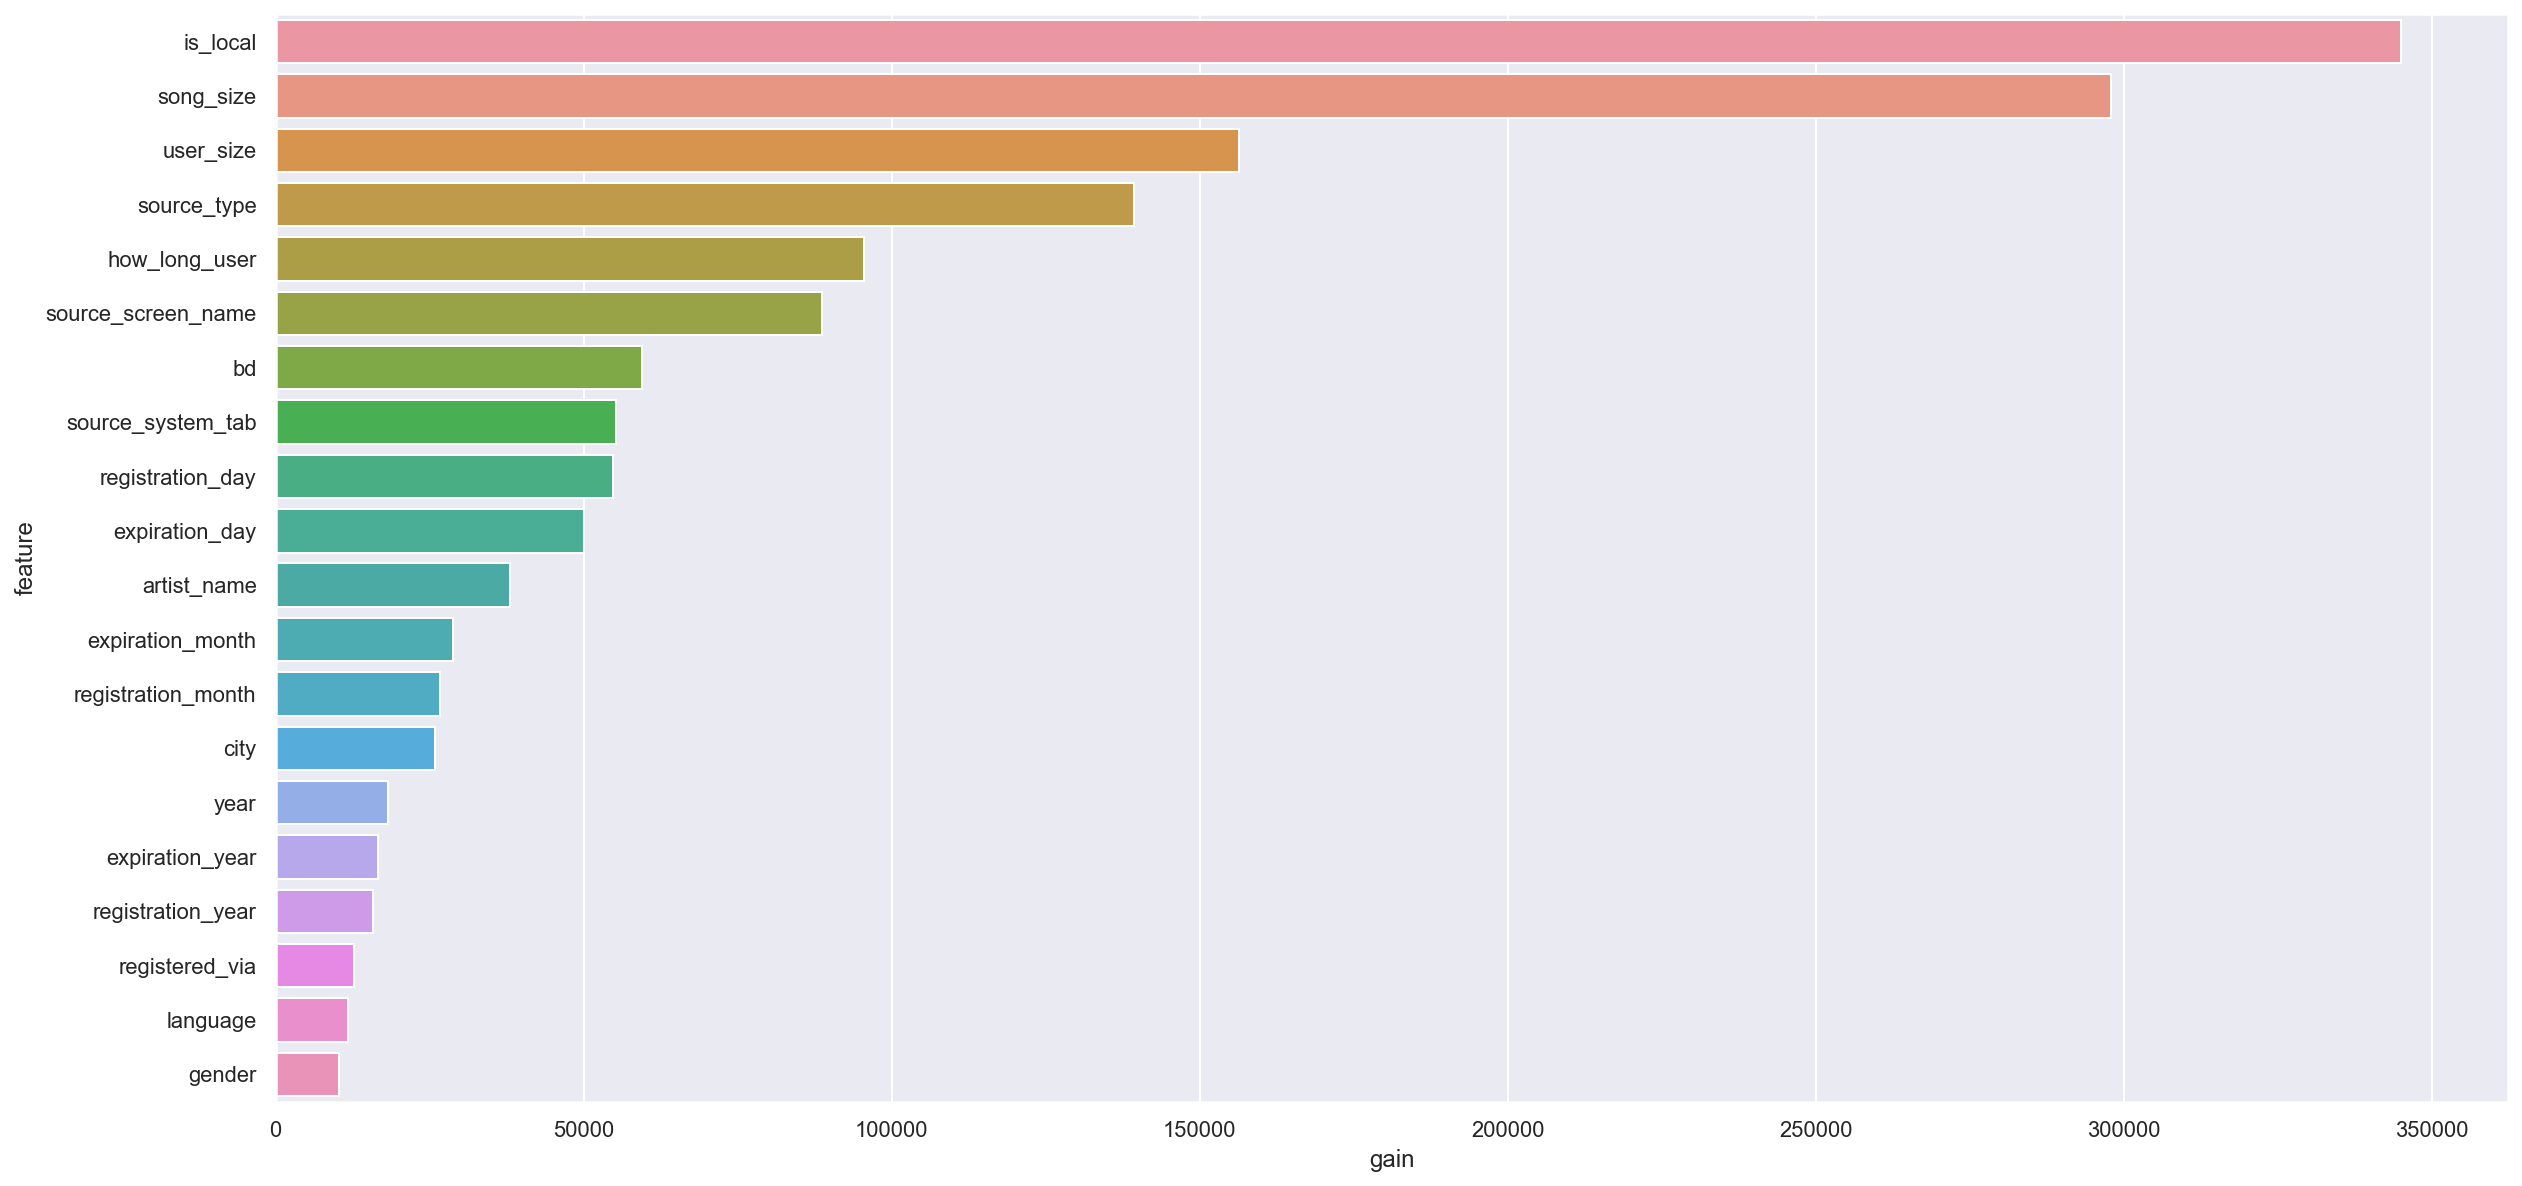

In [114]:
plot_importance(cb_clf.booster_, importance_type='gain')

Опционально можно построить важности признаков при помощи [shap](https://github.com/slundberg/shap)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


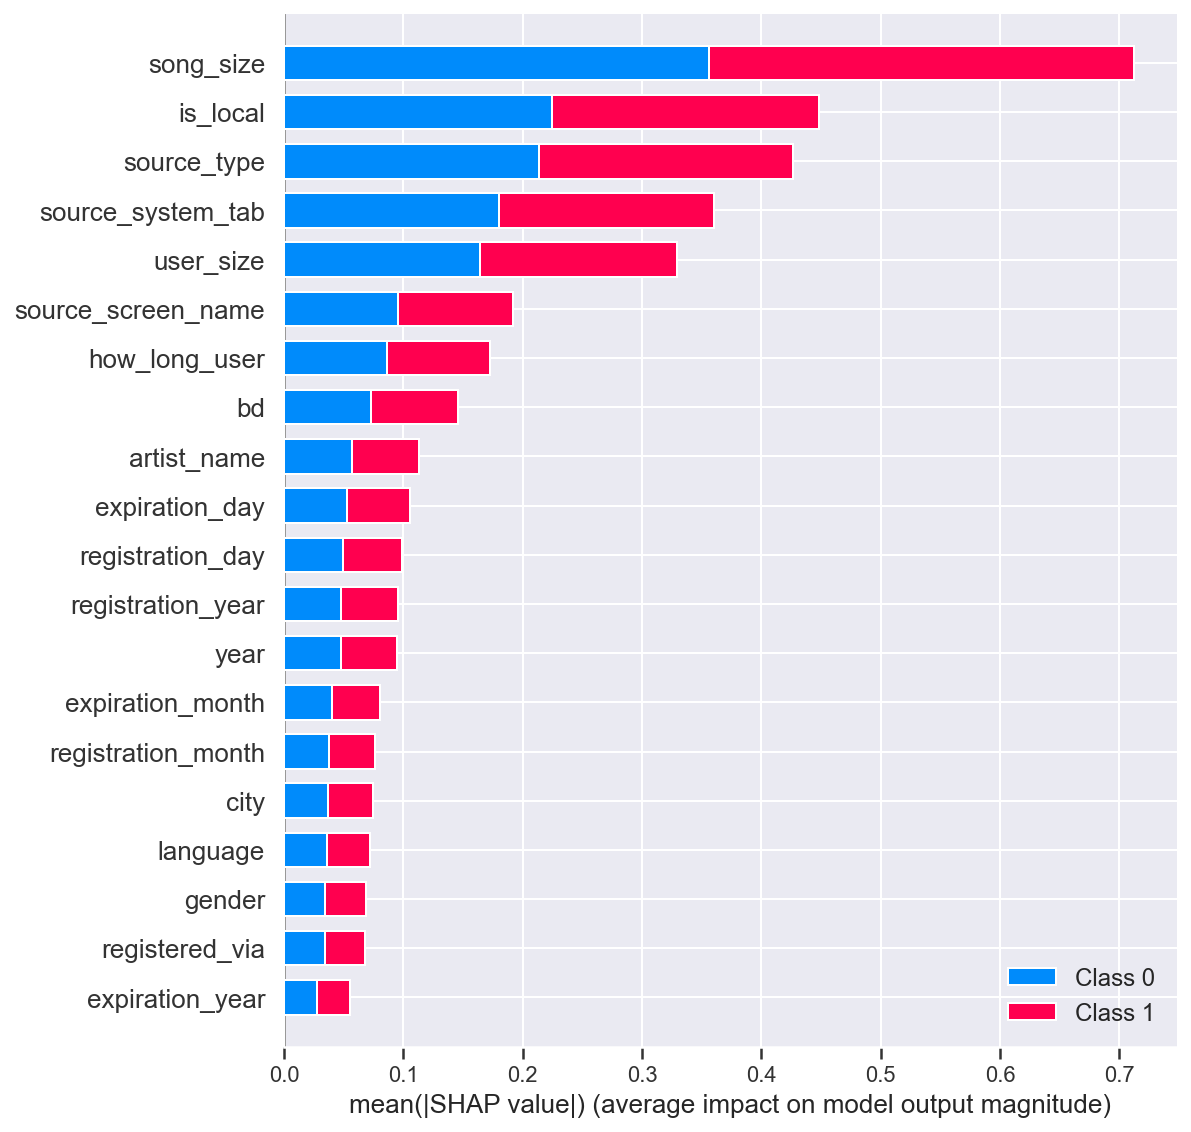

In [119]:
X_train_transformed = cb_enc.fit_transform(X_train, y_train)
import shap 
shap.initjs()
shap_values = shap.TreeExplainer(cb_clf.booster_).shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed)

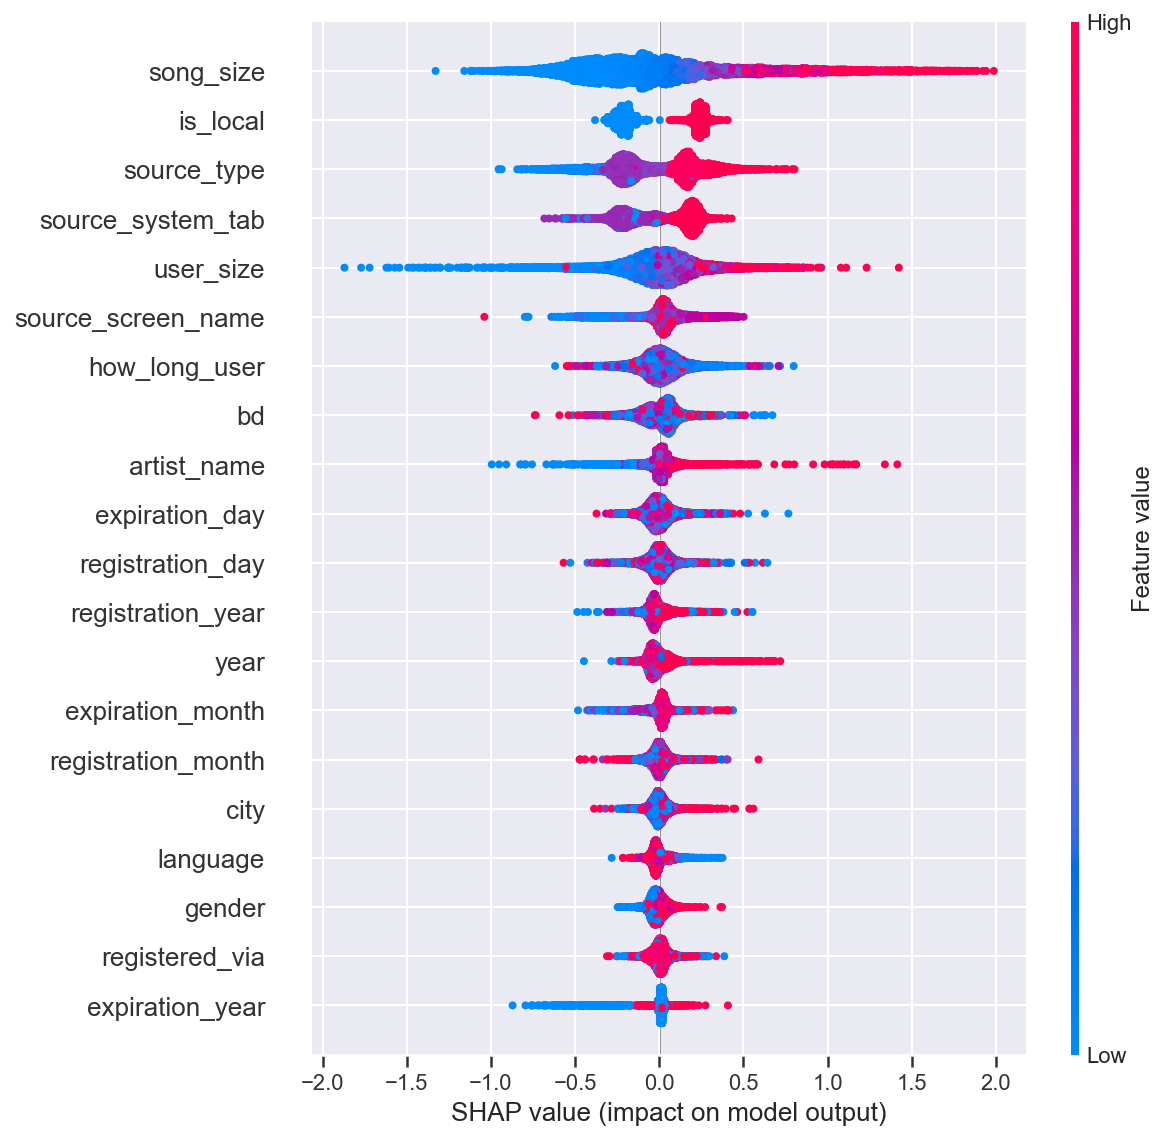

In [123]:
shap_values = shap.TreeExplainer(cb_clf.booster_).shap_values(X_train_transformed)
shap.summary_plot(shap_values[1], X_train_transformed)

# Hyperparameter optimization
Там достаточно большой вывод в одной из ячеек, но основные итоги следующие:
* можно действительно улучшить скор (улучшил с 0.7536 до 0.7802, а если учить ещё дольше, то до **0.80689!**)
* не писал подбор вручную, так как в этой библиотеке, на удивление, достаточно неплохо реализовано (всего проверилось около 80 различных конфигураций)
* нет переобучения:
```
train auc: 0.7974699920279862
val auc: 0.7846464170836339
```

In [40]:
import optuna
import optuna.integration.lightgbm as lgb_opt
optuna.__version__

'2.2.0'

In [41]:
X_train_transformed = james_encoder.fit_transform(X_train, y_train)
X_valid_transformed = james_encoder.transform(X_valid)

C:\Anaconda3\envs\sdc\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [42]:
d_train = lgb_opt.Dataset(X_train_transformed, label=y_train, feature_name=feature_names, free_raw_data=False)
d_valid = lgb_opt.Dataset(X_valid_transformed, label=y_valid, feature_name=feature_names, free_raw_data=False)
gc.collect()

22

In [43]:
boosting_static_params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": 0,
        "boosting_type": "gbdt",
}

In [44]:
study = optuna.create_study(direction="maximize")

[I 2020-11-04 05:16:23,768] A new study created in memory with name: no-name-65686dee-43a9-49c0-a630-fbf3dc5346c5


In [45]:
from datetime import timedelta
time_to_train = timedelta(hours=2.5).seconds

In [46]:
model = lgb_opt.train(
        params=boosting_static_params, 
        train_set=d_train, valid_sets=[d_valid], 
        early_stopping_rounds=30, num_boost_round=300,
        verbose_eval=0, 
        study=study, time_budget=time_to_train,
        model_dir='boostings-auc',
)

feature_fraction, val_score: -inf:   0%|                                                 | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321845 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 05:17:57,486] The booster of trial#0 was saved as boostings-auc\0.pkl.
feature_fraction, val_score: 0.729905:  14%|#####2                               | 1/7 [01:21<08:11, 81.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:19:01,681] The booster of trial#1 was saved as boostings-auc\1.pkl.
feature_fraction, val_score: 0.729905:  29%|##########5                          | 2/7 [02:26<06:23, 76.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:20:09,345] The booster of trial#2 was saved as boostings-auc\2.pkl.
feature_fraction, val_score: 0.729905:  43%|###############8                     | 3/7 [03:33<04:55, 73.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:21:13,204] The booster of trial#3 was saved as boostings-auc\3.pkl.
feature_fraction, val_score: 0.729974:  57%|#####################1               | 4/7 [04:37<03:32, 70.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:22:21,753] The booster of trial#4 was saved as boostings-auc\4.pkl.
feature_fraction, val_score: 0.729974:  71%|##########################4          | 5/7 [05:46<02:20, 70.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:23:26,073] The booster of trial#5 was saved as boostings-auc\5.pkl.
feature_fraction, val_score: 0.729974:  86%|###############################7     | 6/7 [06:50<01:08, 68.44s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:24:28,962] The booster of trial#6 was saved as boostings-auc\6.pkl.
num_leaves, val_score: 0.730922:   0%|                                                  | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:25:48,344] The booster of trial#7 was saved as boostings-auc\7.pkl.
num_leaves, val_score: 0.777026:   5%|##1                                       | 1/20 [01:19<25:08, 79.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286522 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 05:27:18,189] The booster of trial#8 was saved as boostings-auc\8.pkl.
num_leaves, val_score: 0.777026:  10%|####2                                     | 2/20 [02:49<24:45, 82.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:28:18,808] The booster of trial#9 was saved as boostings-auc\9.pkl.
num_leaves, val_score: 0.777026:  15%|######3                                   | 3/20 [03:49<21:31, 75.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:29:38,066] The booster of trial#10 was saved as boostings-auc\10.pkl.
num_leaves, val_score: 0.777026:  20%|########4                                 | 4/20 [05:09<20:31, 76.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:31:03,010] The booster of trial#11 was saved as boostings-auc\11.pkl.
num_leaves, val_score: 0.777464:  25%|##########5                               | 5/20 [06:34<19:50, 79.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:32:24,395] The booster of trial#12 was saved as boostings-auc\12.pkl.
num_leaves, val_score: 0.777562:  30%|############6                             | 6/20 [07:55<18:39, 79.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296106 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 05:33:59,787] The booster of trial#13 was saved as boostings-auc\13.pkl.
num_leaves, val_score: 0.777562:  35%|##############7                           | 7/20 [09:30<18:19, 84.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:35:14,917] The booster of trial#14 was saved as boostings-auc\14.pkl.
num_leaves, val_score: 0.777562:  40%|################8                         | 8/20 [10:45<16:20, 81.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:36:32,994] The booster of trial#15 was saved as boostings-auc\15.pkl.
num_leaves, val_score: 0.777562:  45%|##################9                       | 9/20 [12:04<14:47, 80.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304157 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 05:37:54,794] The booster of trial#16 was saved as boostings-auc\16.pkl.
num_leaves, val_score: 0.777562:  50%|####################5                    | 10/20 [13:25<13:29, 80.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:39:10,338] The booster of trial#17 was saved as boostings-auc\17.pkl.
num_leaves, val_score: 0.777562:  55%|######################5                  | 11/20 [14:41<11:54, 79.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:40:27,296] The booster of trial#18 was saved as boostings-auc\18.pkl.
num_leaves, val_score: 0.777562:  60%|########################5                | 12/20 [15:58<10:29, 78.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:41:40,746] The booster of trial#19 was saved as boostings-auc\19.pkl.
num_leaves, val_score: 0.777562:  65%|##########################6              | 13/20 [17:11<08:59, 77.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:42:58,265] The booster of trial#20 was saved as boostings-auc\20.pkl.
num_leaves, val_score: 0.777562:  70%|############################7            | 14/20 [18:29<07:43, 77.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:44:17,299] The booster of trial#21 was saved as boostings-auc\21.pkl.
num_leaves, val_score: 0.777562:  75%|##############################7          | 15/20 [19:48<06:28, 77.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:45:36,669] The booster of trial#22 was saved as boostings-auc\22.pkl.
num_leaves, val_score: 0.777562:  80%|################################8        | 16/20 [21:07<05:12, 78.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:46:53,605] The booster of trial#23 was saved as boostings-auc\23.pkl.
num_leaves, val_score: 0.777562:  85%|##################################8      | 17/20 [22:24<03:53, 77.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:48:08,433] The booster of trial#24 was saved as boostings-auc\24.pkl.
num_leaves, val_score: 0.777562:  90%|####################################9    | 18/20 [23:39<02:33, 76.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:49:28,316] The booster of trial#25 was saved as boostings-auc\25.pkl.
num_leaves, val_score: 0.777562:  95%|######################################9  | 19/20 [24:59<01:17, 77.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:50:49,082] The booster of trial#26 was saved as boostings-auc\26.pkl.
bagging, val_score: 0.777562:   0%|                                                     | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:52:05,146] The booster of trial#27 was saved as boostings-auc\27.pkl.
bagging, val_score: 0.778781:  10%|####5                                        | 1/10 [01:16<11:24, 76.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:53:21,810] The booster of trial#28 was saved as boostings-auc\28.pkl.
bagging, val_score: 0.779577:  20%|#########                                    | 2/10 [02:32<10:09, 76.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304983 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 05:54:50,899] The booster of trial#29 was saved as boostings-auc\29.pkl.
bagging, val_score: 0.779577:  30%|#############5                               | 3/10 [04:01<09:20, 80.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:56:07,274] The booster of trial#30 was saved as boostings-auc\30.pkl.
bagging, val_score: 0.779577:  40%|##################                           | 4/10 [05:18<07:53, 78.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:57:24,411] The booster of trial#31 was saved as boostings-auc\31.pkl.
bagging, val_score: 0.779623:  50%|######################5                      | 5/10 [06:35<06:32, 78.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:58:41,544] The booster of trial#32 was saved as boostings-auc\32.pkl.
bagging, val_score: 0.780100:  60%|###########################                  | 6/10 [07:52<05:12, 78.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 05:59:57,973] The booster of trial#33 was saved as boostings-auc\33.pkl.
bagging, val_score: 0.780100:  70%|###############################4             | 7/10 [09:08<03:52, 77.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:01:13,334] The booster of trial#34 was saved as boostings-auc\34.pkl.
bagging, val_score: 0.780100:  80%|####################################         | 8/10 [10:24<02:33, 76.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:02:24,876] The booster of trial#35 was saved as boostings-auc\35.pkl.
bagging, val_score: 0.780100:  90%|########################################5    | 9/10 [11:35<01:15, 75.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307492 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 06:04:10,832] The booster of trial#36 was saved as boostings-auc\36.pkl.
feature_fraction_stage2, val_score: 0.780100:   0%|                                      | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:05:27,727] The booster of trial#37 was saved as boostings-auc\37.pkl.
feature_fraction_stage2, val_score: 0.780100:  33%|##########                    | 1/3 [01:16<02:33, 76.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:06:45,238] The booster of trial#38 was saved as boostings-auc\38.pkl.
feature_fraction_stage2, val_score: 0.780100:  67%|####################          | 2/3 [02:34<01:17, 77.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:08:01,691] The booster of trial#39 was saved as boostings-auc\39.pkl.
regularization_factors, val_score: 0.780234:   0%|                                      | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:09:18,602] The booster of trial#40 was saved as boostings-auc\40.pkl.
regularization_factors, val_score: 0.780234:   5%|#5                            | 1/20 [01:16<24:21, 76.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:10:35,219] The booster of trial#41 was saved as boostings-auc\41.pkl.
regularization_factors, val_score: 0.780234:  10%|###                           | 2/20 [02:33<23:02, 76.82s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284295 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 06:11:59,353] The booster of trial#42 was saved as boostings-auc\42.pkl.
regularization_factors, val_score: 0.780234:  15%|####5                         | 3/20 [03:57<22:23, 79.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:13:16,785] The booster of trial#43 was saved as boostings-auc\43.pkl.
regularization_factors, val_score: 0.780234:  20%|######                        | 4/20 [05:15<20:56, 78.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.285680 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 06:14:41,059] The booster of trial#44 was saved as boostings-auc\44.pkl.
regularization_factors, val_score: 0.780234:  25%|#######5                      | 5/20 [06:39<20:03, 80.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:15:57,847] The booster of trial#45 was saved as boostings-auc\45.pkl.
regularization_factors, val_score: 0.780234:  30%|#########                     | 6/20 [07:56<18:29, 79.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:17:22,170] The booster of trial#46 was saved as boostings-auc\46.pkl.
regularization_factors, val_score: 0.780234:  35%|##########5                   | 7/20 [09:20<17:29, 80.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:18:39,642] The booster of trial#47 was saved as boostings-auc\47.pkl.
regularization_factors, val_score: 0.780234:  40%|############                  | 8/20 [10:37<15:57, 79.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:19:56,361] The booster of trial#48 was saved as boostings-auc\48.pkl.
regularization_factors, val_score: 0.780234:  45%|#############5                | 9/20 [11:54<14:27, 78.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:21:12,748] The booster of trial#49 was saved as boostings-auc\49.pkl.
regularization_factors, val_score: 0.780234:  50%|##############5              | 10/20 [13:11<13:01, 78.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:22:28,594] The booster of trial#50 was saved as boostings-auc\50.pkl.
regularization_factors, val_score: 0.780234:  55%|###############9             | 11/20 [14:26<11:36, 77.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:23:44,768] The booster of trial#51 was saved as boostings-auc\51.pkl.
regularization_factors, val_score: 0.780234:  60%|#################4           | 12/20 [15:43<10:16, 77.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:25:02,646] The booster of trial#52 was saved as boostings-auc\52.pkl.
regularization_factors, val_score: 0.780234:  65%|##################8          | 13/20 [17:00<09:01, 77.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:26:18,966] The booster of trial#53 was saved as boostings-auc\53.pkl.
regularization_factors, val_score: 0.780234:  70%|####################2        | 14/20 [18:17<07:42, 77.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:27:35,534] The booster of trial#54 was saved as boostings-auc\54.pkl.
regularization_factors, val_score: 0.780234:  75%|#####################7       | 15/20 [19:33<06:24, 76.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282906 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 06:28:59,386] The booster of trial#55 was saved as boostings-auc\55.pkl.
regularization_factors, val_score: 0.780234:  80%|#######################2     | 16/20 [20:57<05:15, 78.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:30:15,725] The booster of trial#56 was saved as boostings-auc\56.pkl.
regularization_factors, val_score: 0.780234:  85%|########################6    | 17/20 [22:14<03:54, 78.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:31:32,167] The booster of trial#57 was saved as boostings-auc\57.pkl.
regularization_factors, val_score: 0.780248:  90%|##########################1  | 18/20 [23:30<02:35, 77.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301673 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-11-04 06:32:57,983] The booster of trial#58 was saved as boostings-auc\58.pkl.
regularization_factors, val_score: 0.780248:  95%|###########################5 | 19/20 [24:56<01:20, 80.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:34:14,184] The booster of trial#59 was saved as boostings-auc\59.pkl.
min_data_in_leaf, val_score: 0.780248:   0%|                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:35:32,843] The booster of trial#60 was saved as boostings-auc\60.pkl.
min_data_in_leaf, val_score: 0.780248:  20%|#######4                             | 1/5 [01:18<05:14, 78.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:36:50,658] The booster of trial#61 was saved as boostings-auc\61.pkl.
min_data_in_leaf, val_score: 0.780248:  40%|##############8                      | 2/5 [02:36<03:55, 78.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:38:07,642] The booster of trial#62 was saved as boostings-auc\62.pkl.
min_data_in_leaf, val_score: 0.780248:  60%|######################2              | 3/5 [03:53<02:35, 77.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:39:25,270] The booster of trial#63 was saved as boostings-auc\63.pkl.
min_data_in_leaf, val_score: 0.780248:  80%|#############################6       | 4/5 [05:11<01:17, 77.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2020-11-04 06:40:42,911] The booster of trial#64 was saved as boostings-auc\64.pkl.
min_data_in_leaf, val_score: 0.780248: 100%|#####################################| 5/5 [06:28<00:00, 77.74s/it]


In [47]:
study.best_value

0.7802475431200588

### Дообучение с лучшими параметрами

In [62]:
import lightgbm as lgb

In [63]:
def fit_more(num_boost_round, learning_rate):
    return lgb.train(
            params={**boosting_static_params, **study.best_params, 'learning_rate': learning_rate},
            train_set=d_train, valid_sets=[d_valid],
            feature_name=feature_names, categorical_feature=categorical_columns,
            init_model=model,
            verbose_eval=300,
            early_stopping_rounds=60, num_boost_round=num_boost_round)

In [51]:
model_retrained = fit_more(num_boost_round=1800, learning_rate=0.03)

C:\Anaconda3\envs\sdc\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'city', 'gender', 'genre_ids', 'language', 'main_genre', 'registered_via', 'source_screen_name', 'source_system_tab', 'source_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Anaconda3\envs\sdc\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Anaconda3\envs\sdc\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 60 rounds
[600]	valid_0's auc: 0.781002
[900]	valid_0's auc: 0.781749
[1200]	valid_0's auc: 0.78243
[1500]	valid_0's auc: 0.783185
[1800]	valid_0's auc: 0.783961
[2100]	valid_0's auc: 0.784646
Did not meet early stopping. Best iteration is:
[2100]	valid_0's auc: 0.784646


In [64]:
print(f'train auc: {roc_auc_score(y_train, model_retrained.predict(X_train_transformed))}')
print(f'val auc: {roc_auc_score(y_valid, model_retrained.predict(X_valid_transformed))}')

train auc: 0.7974699920279862
val auc: 0.7846464170836339


In [57]:
%%time
model_retrained_even_more = fit_more(num_boost_round=15600, learning_rate=0.07)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 60 rounds
[600]	valid_0's auc: 0.782
[900]	valid_0's auc: 0.783677
[1200]	valid_0's auc: 0.785212
[1500]	valid_0's auc: 0.78649
[1800]	valid_0's auc: 0.787507
[2100]	valid_0's auc: 0.788525
[2400]	valid_0's auc: 0.789513
[2700]	valid_0's auc: 0.790417
[3000]	valid_0's auc: 0.791527
[3300]	valid_0's auc: 0.792515
[3600]	valid_0's auc: 0.793224
[3900]	valid_0's auc: 0.793859
[4200]	valid_0's auc: 0.794637
[4500]	valid_0's auc: 0.795327
[4800]	valid_0's auc: 0.795896
[5100]	valid_0's auc: 0.79636
[5400]	valid_0's auc: 0.796821
[5700]	valid_0's auc: 0.797315
[6000]	valid_0's auc: 0.797792
[6300]	valid_0's auc: 0.798246
[6600]	valid_0's auc: 0.79867
[6900]	valid_0's auc: 0.799076
[7200]	valid_0's auc: 0.799501
[7500

In [65]:
print(f'val auc: {roc_auc_score(y_valid, model_retrained_even_more.predict(X_valid_transformed))}')

val auc: 0.8068936308690249


# Часть 2. Нетрадиционные ( ͡° ͜ʖ ͡°)
К сожалению мы не можем ориентироваться только на song_id, так как иногда те же самые песни от тех же самых авторов отличаются по этому полю.

Давайте агрегируем какие песни прослушал каждый пользователь, и обучим на этом **fasttext!**

In [8]:
songs = pd.read_csv(data_path / 'songs.csv')
song_extra_info = pd.read_csv(data_path / 'song_extra_info.csv')

In [9]:
songs = songs.merge(song_extra_info, on='song_id', how='left')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


In [10]:
songs['new_song_id'] = songs['artist_name'].str.lower().str.replace(' ', '') + "_" + songs['name'].str.lower().str.replace(' ', '')

In [11]:
songs = songs[['song_id', 'new_song_id']]

In [12]:
songs.head()

,song_id,new_song_id
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,張信哲(jeffchang)_焚情
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,blackpink_playingwithfire
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,superjunior_sorry|sorry
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,s.h.e_愛我的資格
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,貴族精選_maryhadalittlelamb


In [13]:
train = pd.read_csv(data_path / 'train.csv')

In [14]:
train = train.merge(songs, on='song_id', how='left')

In [15]:
train = train[['msno', 'new_song_id']]

In [16]:
del songs, song_extra_info
gc.collect()

166

In [17]:
train.head()

,msno,new_song_id
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bastille_goodgrief
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,variousartists_lordsofcardboard
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,nas_hiphopisdead(albumversion(edited))
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,soundway_discoafrica
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,brettyoung_sleepwithoutyou


In [18]:
grouped = train.groupby(by='msno')['new_song_id'].agg(list).reset_index(name='listened_songs')

In [19]:
grouped.head(3)

,msno,listened_songs
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,"[variousartists_hangaround, variousartists_its..."
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,"[五月天(mayday)_溫柔, 林宥嘉(yogalin)_傻子, variousartis..."
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,"[華晨宇_地球之鹽(thesaltoftheearth), 華晨宇_趁你還年輕, 華晨宇_拆..."


In [20]:
def save_fasttext_format(X, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for i, row in X.iterrows():
            print(*row['listened_songs'], file=f)
            
save_fasttext_format(grouped, 'train.txt')

In [21]:
import fasttext
import os

In [23]:
model_name = "model_file.bin"
if os.path.isfile(model_name):
    # model already trained
    model = fasttext.load_model(model_name)
else:
    # let's train model from the scratch
    model = fasttext.train_unsupervised('train.txt', 'skipgram')
    model.save_model(model_name)

### Посмотрим на симилары глазами
(если что, то, оказывается `Bad Meets Evil` — это дует, куда входит эминем

In [37]:
model.get_nearest_neighbors("eminem_themonster")

[(0.8806847333908081, 'eminem_notafraid'),
 (0.8560709357261658, 'eminem_loseyourself'),
 (0.8309026956558228, 'eminem_thewayiam'),
 (0.8130269050598145, 'eminem_legacy'),
 (0.80655837059021, 'eminem_8mile'),
 (0.8062191009521484, 'badmeetsevil_lighters'),
 (0.8061438798904419, 'eminem_coldwindblows'),
 (0.8028871417045593, 'eminem_beautifulpain'),
 (0.802297055721283, 'eminem_lovegame'),
 (0.8004427552223206, 'eminem_stan')]

In [38]:
model.get_nearest_neighbors("thechainsmokers_settingfires")

[(0.8531227111816406, 'thechainsmokers_closer'),
 (0.8331394791603088, 'thechainsmokers_allweknow'),
 (0.8190445899963379, 'martingarrix|beberexha_inthenameoflove'),
 (0.7905128598213196, 'mikeperry_theocean'),
 (0.7894287109375, "thechainsmokers_don'tletmedown"),
 (0.7790114879608154, 'alanwalker_singmetosleep'),
 (0.7733591794967651, 'marshmello_alone'),
 (0.772584855556488, 'theweeknd_starboy'),
 (0.7716007232666016, 'calvinharris_myway'),
 (0.7681466937065125, 'calvinharris_thisiswhatyoucamefor')]

In [39]:
model.get_nearest_neighbors("imaginedragons_ontopoftheworld")

[(0.8515654802322388, 'imaginedragons_summer'),
 (0.844871461391449, 'imaginedragons_coverup'),
 (0.8444693088531494,
  'imaginedragons_ontopoftheworld(samsunggalaxynote8.0電視廣告曲、電影「古魯家族」預告曲)'),
 (0.8412243723869324, 'imaginedragons_itcomesbacktoyou'),
 (0.8354383707046509, 'imaginedragons_shots'),
 (0.8332424759864807, 'imaginedragons_roots'),
 (0.8328569531440735, 'imaginedragons_friction'),
 (0.8308634757995605, 'imaginedragons_tiptoe'),
 (0.8292592763900757, 'imaginedragons_gold'),
 (0.8292241096496582, 'imaginedragons_cha-ching(tillwegrowolder)')]

In [28]:
model.get_nearest_neighbors("50cent_indaclub")

[(0.8640819787979126, '50cent_discoinferno'),
 (0.8449276089668274, '50cent_p.i.m.p.'),
 (0.837417483329773, '50cent_ayotechnology'),
 (0.8302636742591858, '50cent_intro'),
 (0.8222116231918335, '50cent_fire'),
 (0.8093037009239197, "50cent_i'mtheman"),
 (0.8083536028862, '50cent_followmylead'),
 (0.8077099919319153, "50cent_i'llstillkill"),
 (0.8056734800338745, '50cent_9shots'),
 (0.8040669560432434, '50cent_peepshow')]

**Выглядит очень и очень неплохо**

In [40]:
import gensim

In [41]:
gensim_model = gensim.models.fasttext.load_facebook_vectors(model_name)

In [42]:
gensim_model.most_similar('adele_rollinginthedeep')

C:\Miniconda3\envs\recsys\lib\site-packages\gensim\models\keyedvectors.py:2389: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


[('adele_someonelikeyou', 0.9234693646430969),
 ('adele_hello', 0.8725507855415344),
 ('avrillavigne_wishyouwerehere(希望你在身邊)', 0.816734254360199),
 ('carlyraejepsen_ireallylikeyou', 0.8140990138053894),
 ('colbiecaillat_try', 0.8132349252700806),
 ('maroon5_maps', 0.7971861958503723),
 ('imaginedragons_demons(電影「跨越世紀的情書」預告曲、美國職棒大聯盟一週好球)', 0.7867384552955627),
 ('maroon5_onemorenight', 0.7827638387680054),
 ('maroon5_loststars', 0.7818788290023804),
 ('markronsonfeat.brunomars_uptownfunk', 0.7811099290847778)]

### В качестве рекоммендера вместо GBDT

In [113]:
user_embeddings_cache = {}
listened_songs = grouped.set_index('msno').to_dict()['listened_songs']

def get_user_embedding(row):
    if row['msno'] not in user_embeddings_cache:
        embedding = np.zeros(gensim_model.vector_size)
        for song in listened_songs[row['msno']]:
            embedding += gensim_model[str(song)]
        user_embeddings_cache[row['msno']] = embedding
    return user_embeddings_cache[row['msno']]

user_embeddings = np.vstack(train.progress_apply(get_user_embedding, axis=1))

In [100]:
def get_item_embedding(row):
    return gensim_model[row['new_song_id']]
    
item_embeddings = np.vstack(train.progress_apply(get_item_embedding, axis=1))

In [119]:
scores = (item_embeddings * user_embeddings).mean(axis=1)

In [287]:
original_train = pd.read_csv(data_path / 'train.csv')

In [288]:
roc_auc_score(original_train['target'], scores)

0.593589861540871

Скор, конечно ниже, но мы не использовали никакие метаданные совсем.

### стек с GBDT

In [44]:
X['score_from_fasttext'] = scores

In [54]:
james_enc_fitted, james_clf = test_perfomance(james_encoder, get_classifier(), X_train, X_valid, y_train, y_valid)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.751021	training's binary_logloss: 0.589178	valid_1's auc: 0.745374	valid_1's binary_logloss: 0.599874
[200]	training's auc: 0.763465	training's binary_logloss: 0.578402	valid_1's auc: 0.75679	valid_1's binary_logloss: 0.590488
[300]	training's auc: 0.772462	training's binary_logloss: 0.570246	valid_1's auc: 0.764838	valid_1's binary_logloss: 0.583663
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.772462	training's binary_logloss: 0.570246	valid_1's auc: 0.764838	valid_1's binary_logloss: 0.583663
roc-auc: 0.7648381653969146


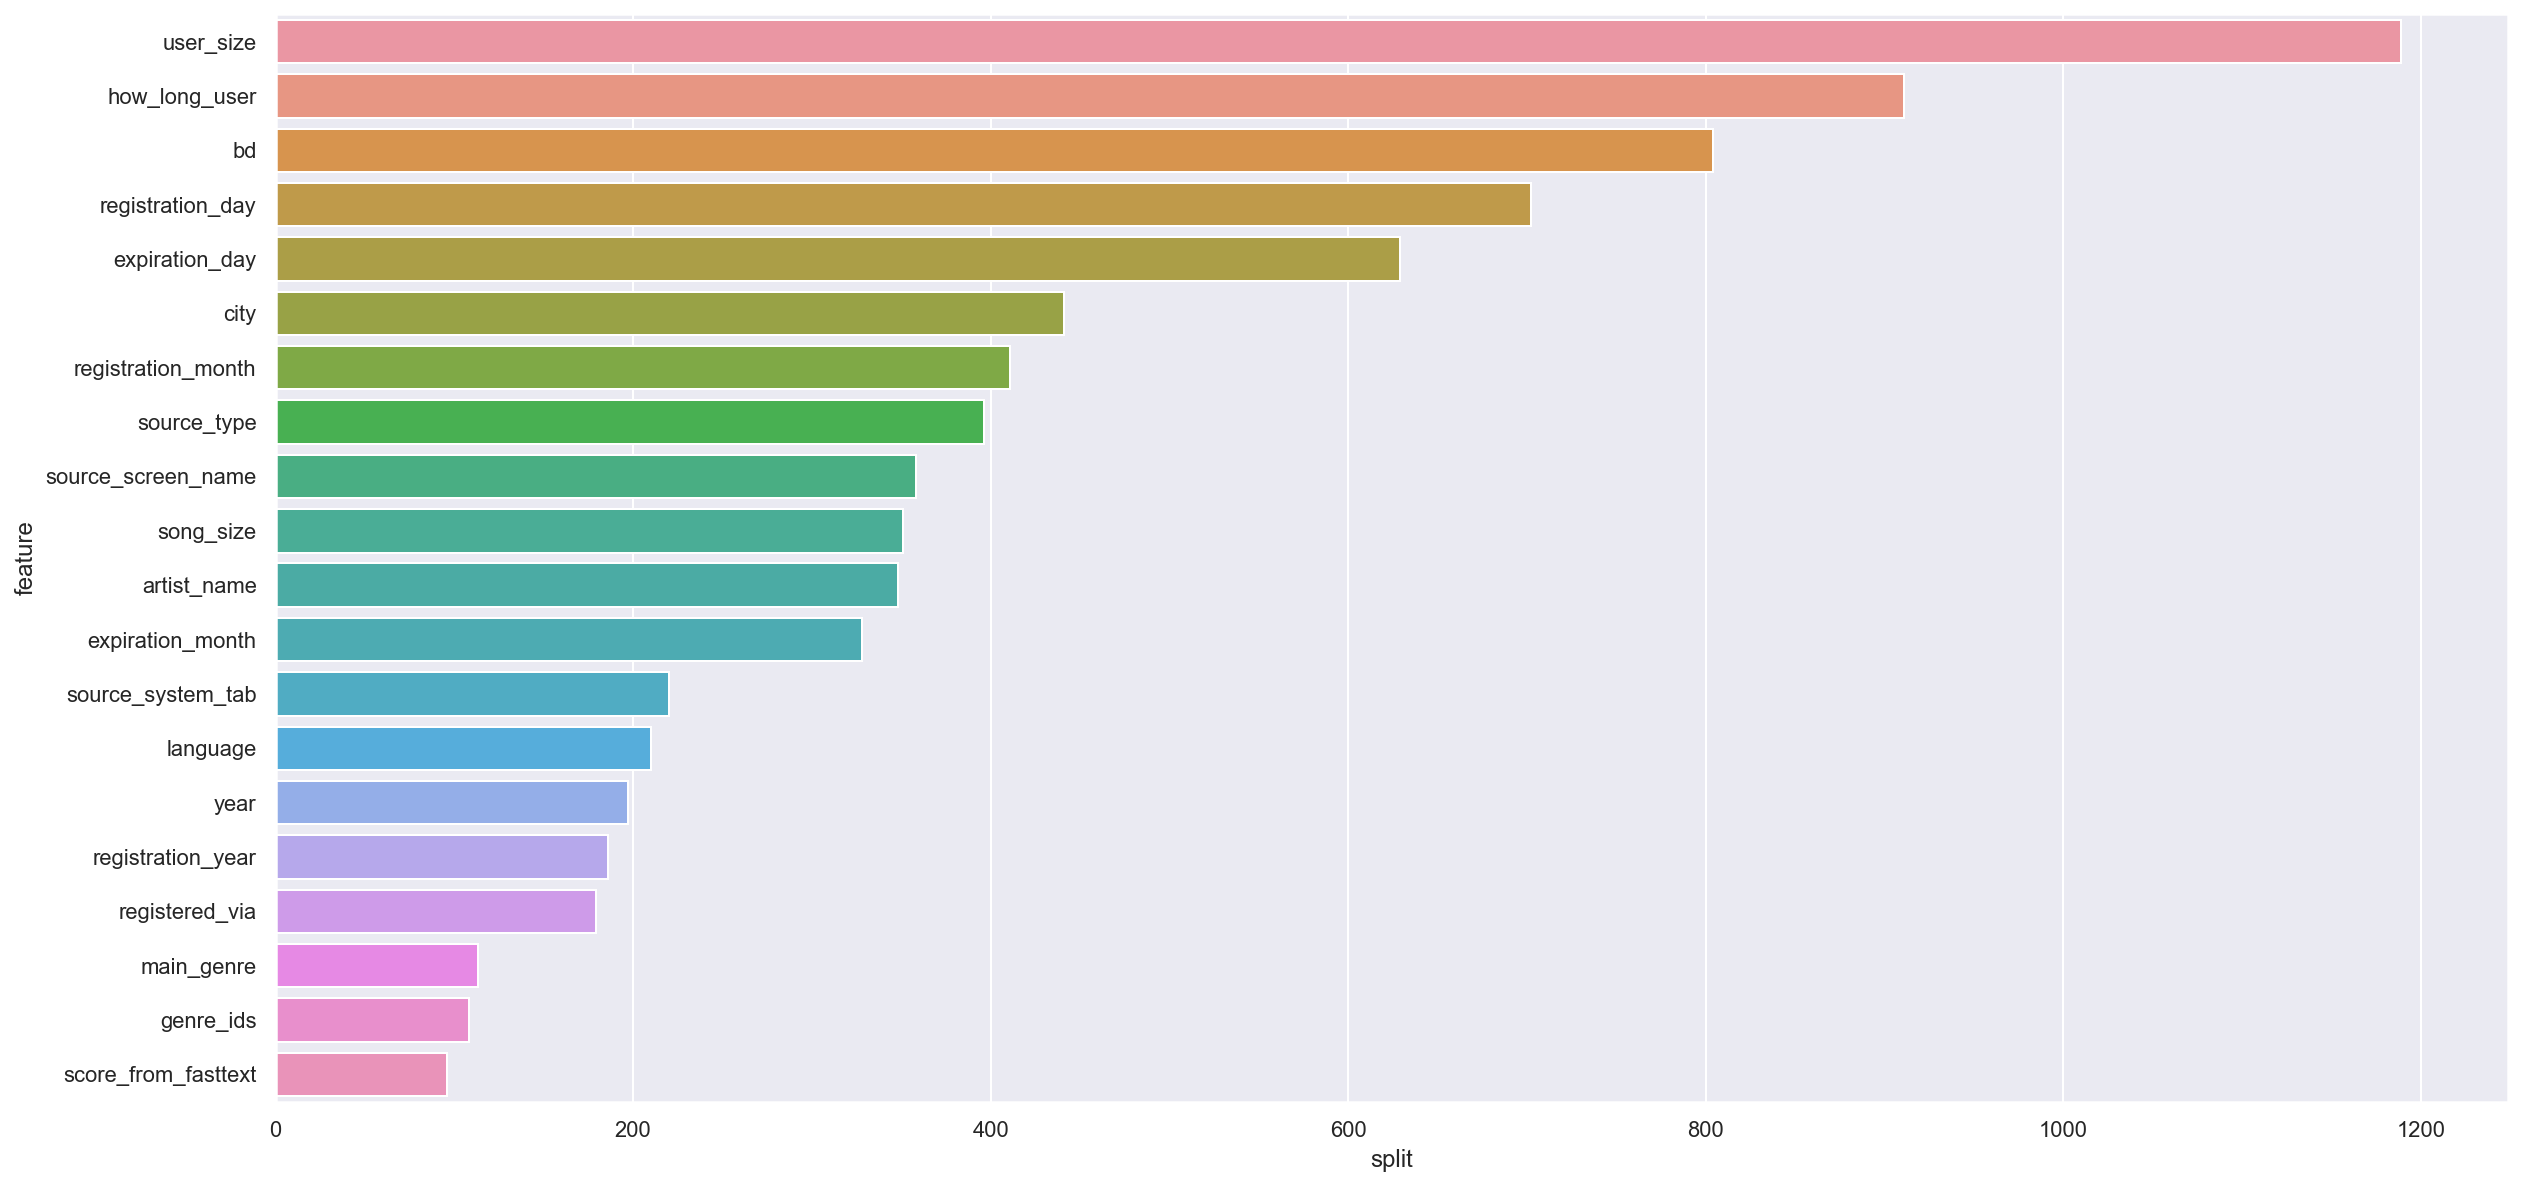

In [65]:
plot_importance(james_clf.booster_, importance_type='split')

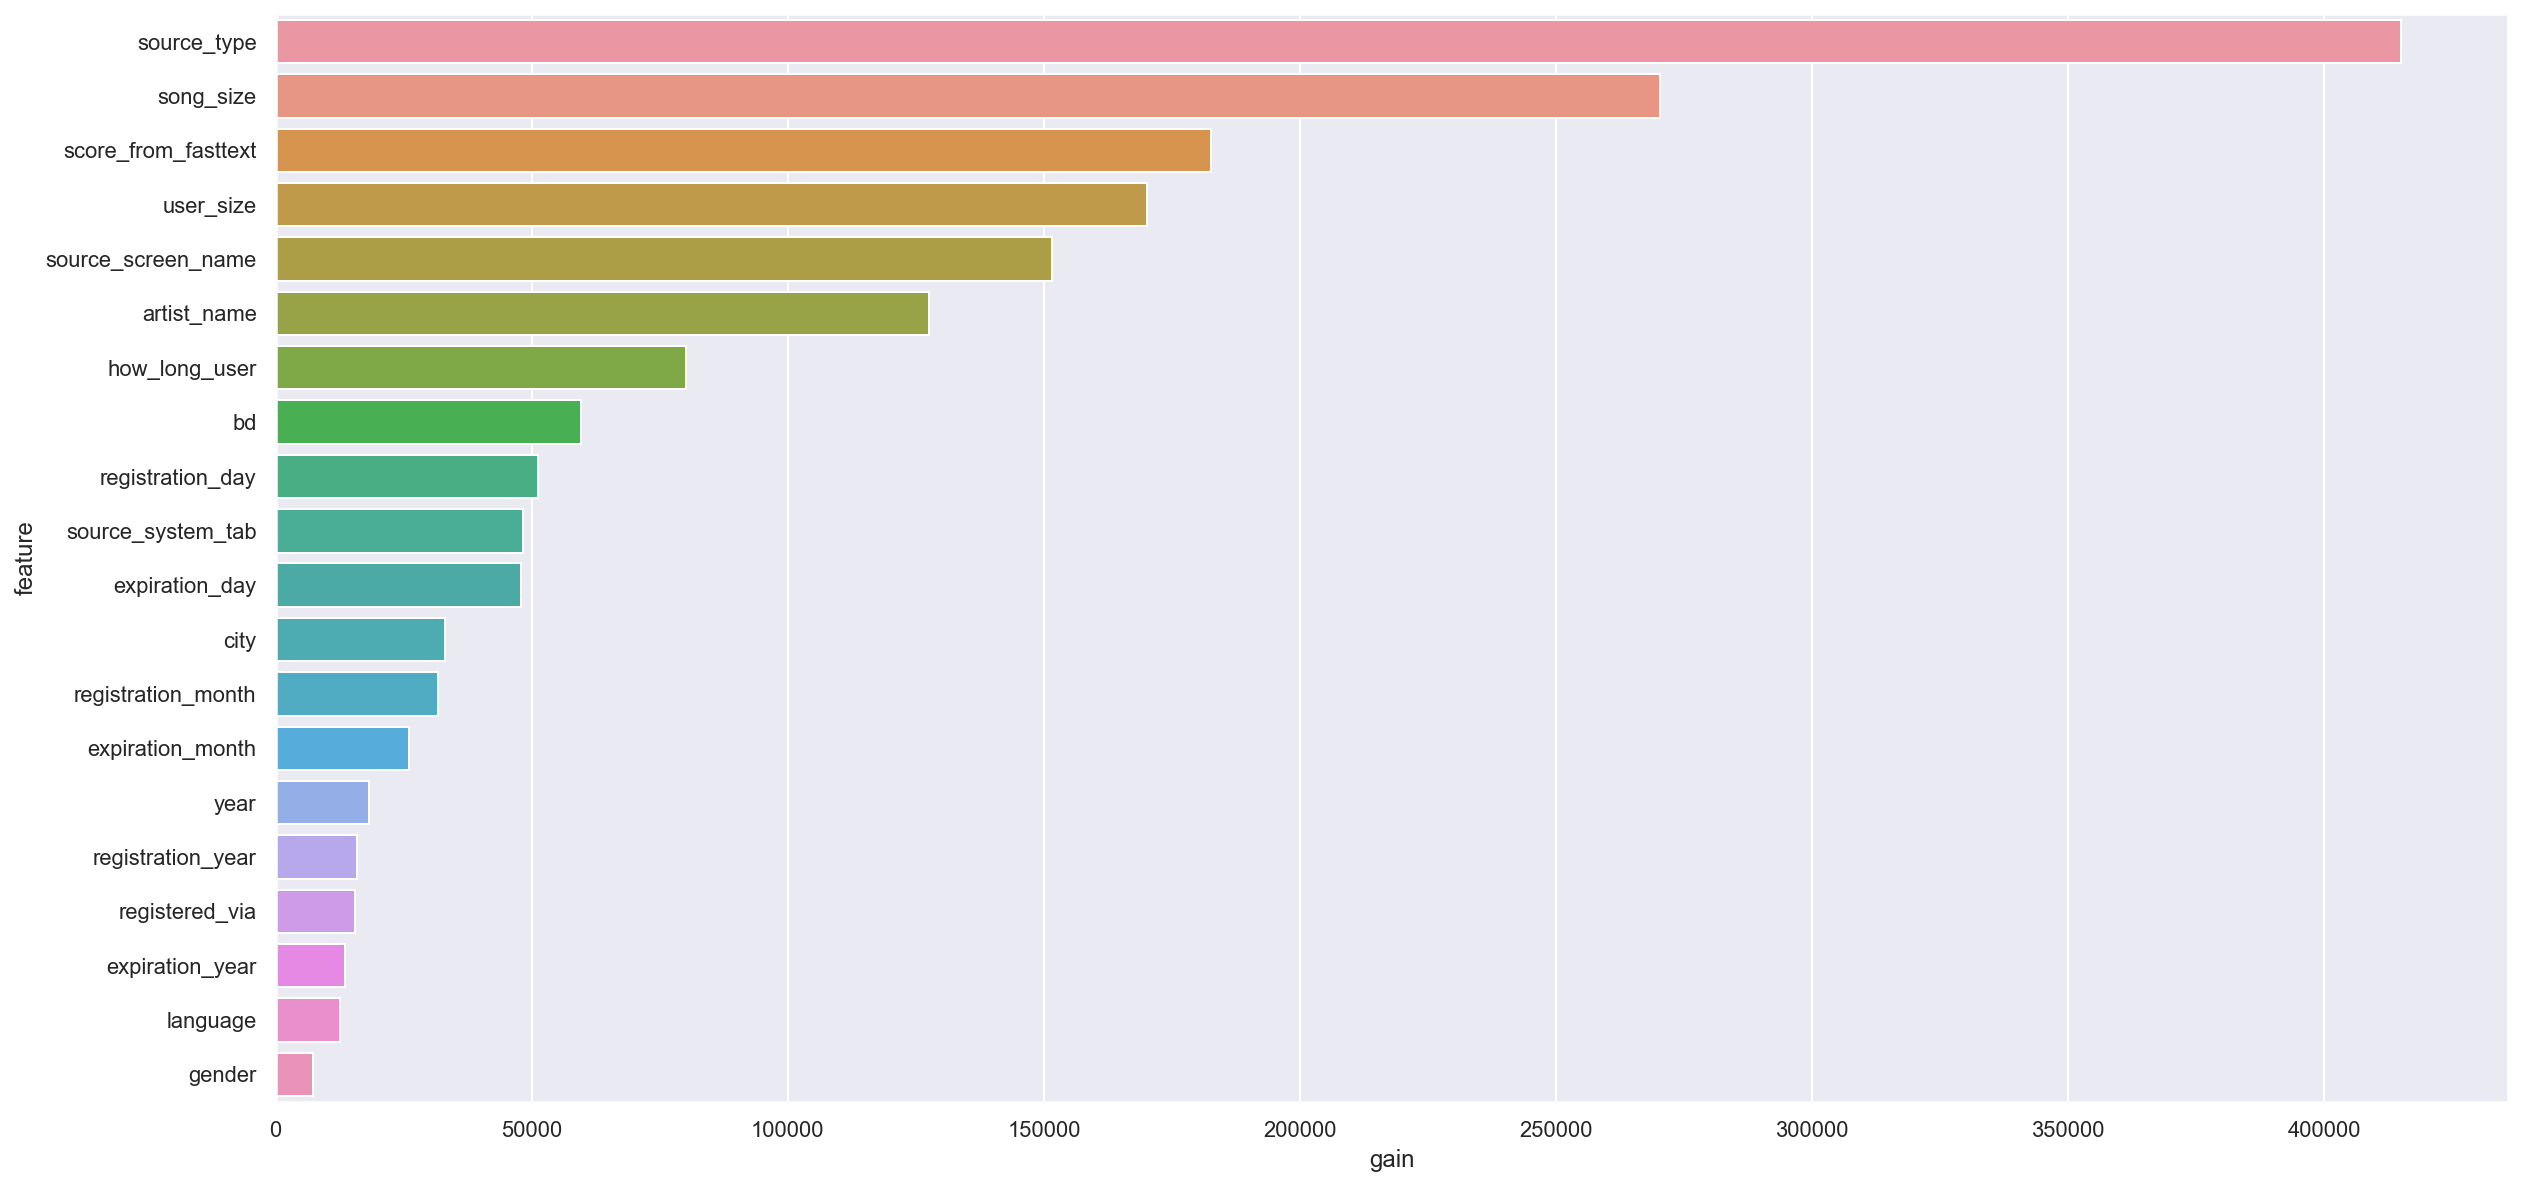

In [64]:
plot_importance(james_clf.booster_, importance_type='gain')

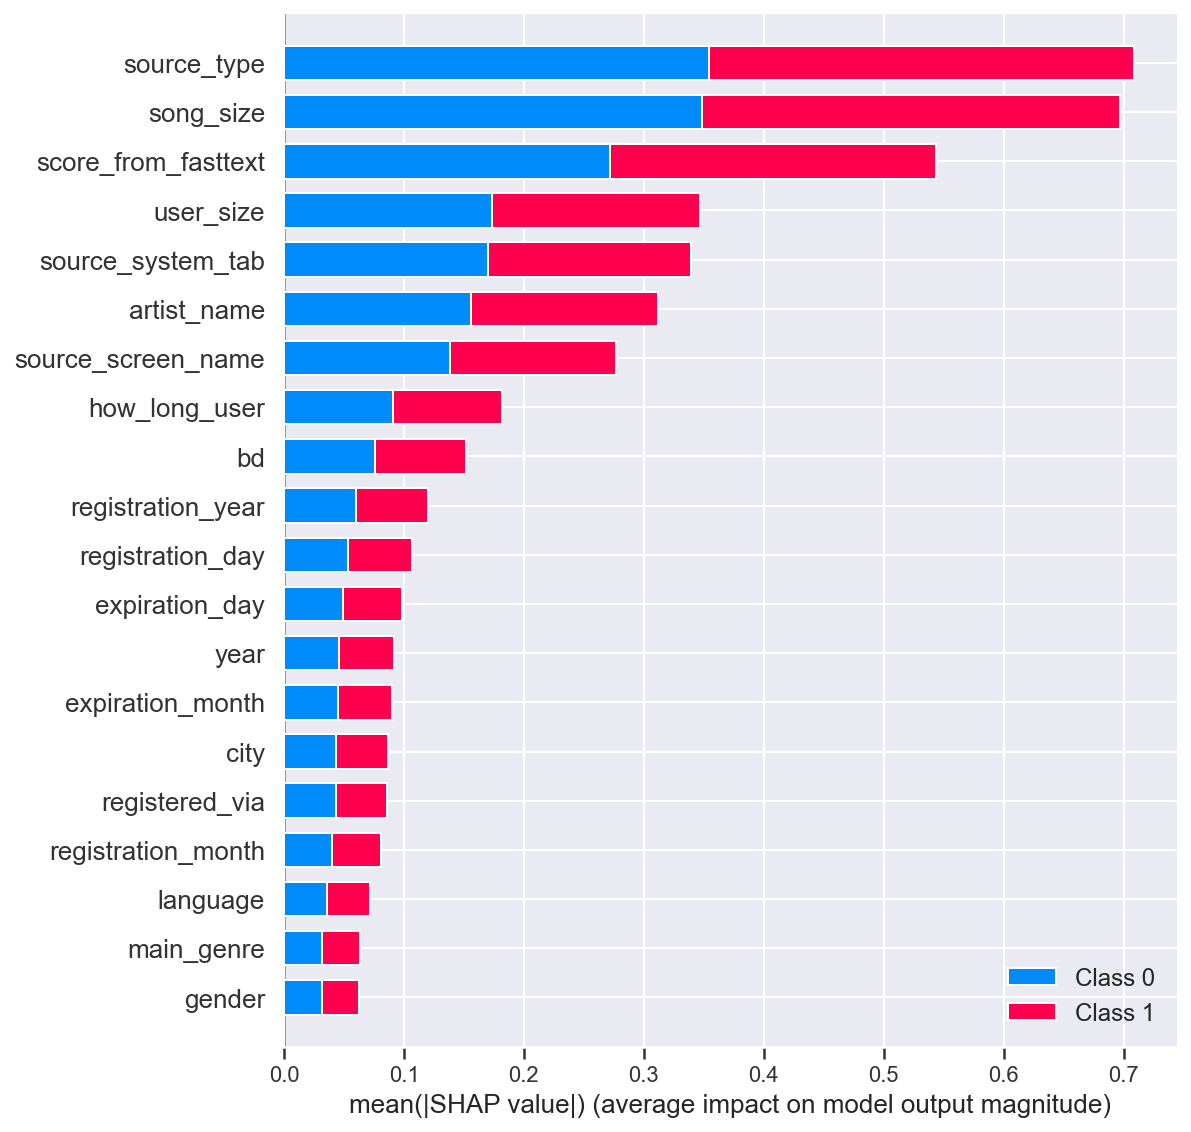

In [63]:
X_train_transformed = james_enc_fitted.fit_transform(X_train, y_train)
import shap 
shap.initjs()
shap_values = shap.TreeExplainer(james_clf.booster_).shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


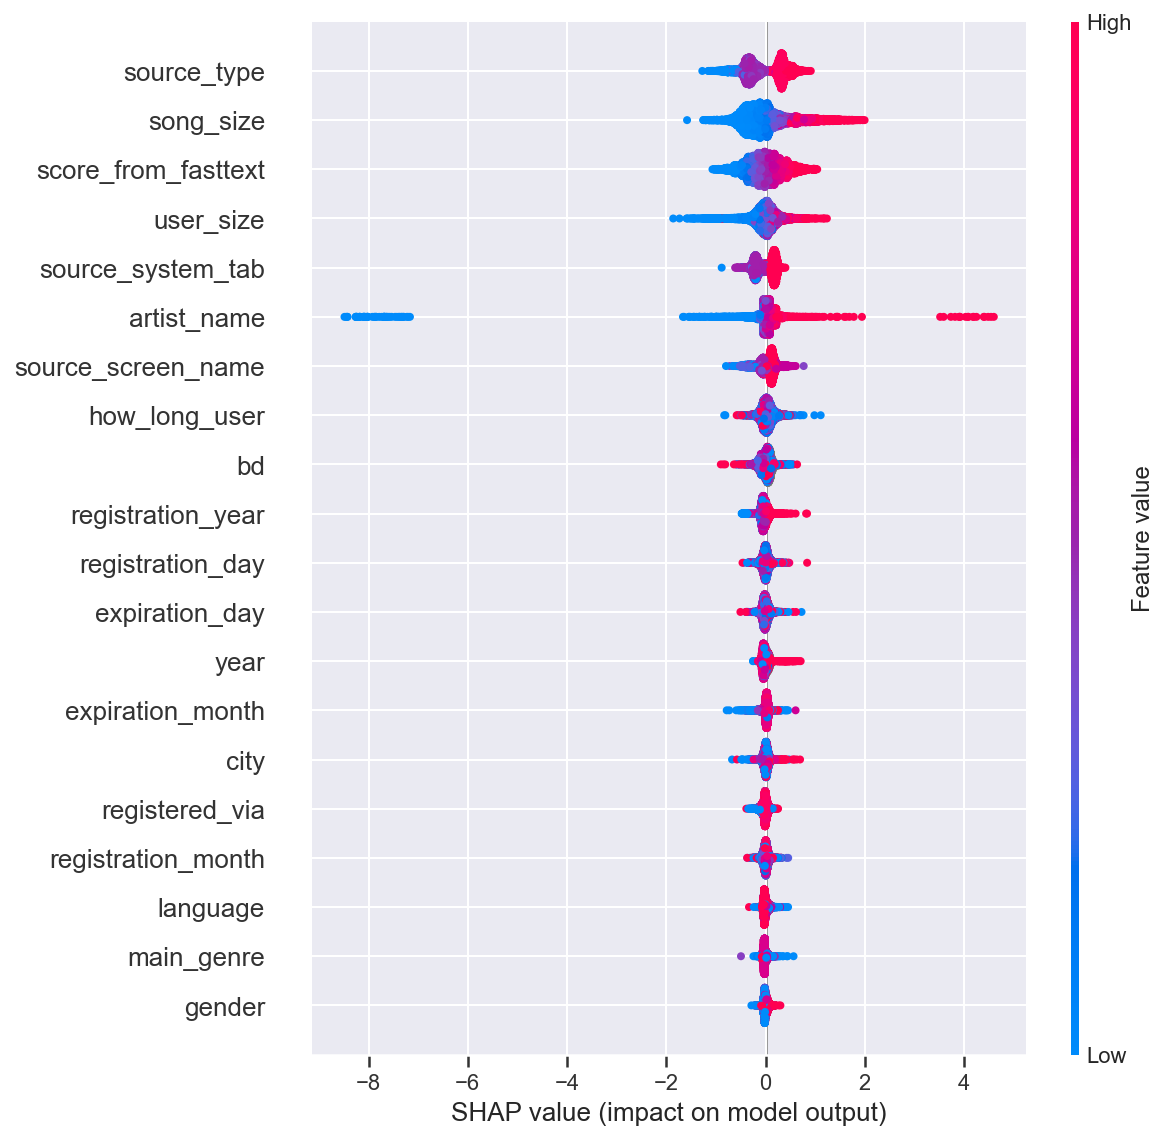

In [67]:
shap_values = shap.TreeExplainer(james_clf.booster_).shap_values(X_train_transformed)
shap.summary_plot(shap_values[1], X_train_transformed)

Видно, что **`score_from_fasttext`** в топе, то есть фича достаточно важная.  
При её добавлении увеличился `auc` на валиде


Что можно было бы ещё:
* добавить в из fasttext'а больше фичей, а не только скор. Например: напрямую embedding'и
* поиграться с размерностью embedding'а